Tarea 2
=====

Epoch [1/50], Train Loss: 1.7806, Train Accuracy: 83.15%, Val Loss: 0.2429, Val Accuracy: 92.30%
Epoch [2/50], Train Loss: 0.6734, Train Accuracy: 93.46%, Val Loss: 0.3302, Val Accuracy: 92.80%
Epoch [3/50], Train Loss: 1.4860, Train Accuracy: 90.93%, Val Loss: 0.2930, Val Accuracy: 92.80%
Epoch [4/50], Train Loss: 0.7834, Train Accuracy: 92.55%, Val Loss: 0.1978, Val Accuracy: 94.91%
Epoch [5/50], Train Loss: 0.3067, Train Accuracy: 92.34%, Val Loss: 0.4309, Val Accuracy: 96.02%
Epoch [6/50], Train Loss: 0.2143, Train Accuracy: 94.82%, Val Loss: 0.1454, Val Accuracy: 95.78%
Epoch [7/50], Train Loss: 0.1809, Train Accuracy: 94.74%, Val Loss: 0.1728, Val Accuracy: 96.52%
Epoch [8/50], Train Loss: 0.1444, Train Accuracy: 95.57%, Val Loss: 0.1369, Val Accuracy: 97.14%
Epoch [9/50], Train Loss: 0.1571, Train Accuracy: 95.65%, Val Loss: 0.1433, Val Accuracy: 95.40%
Epoch [10/50], Train Loss: 0.1371, Train Accuracy: 96.69%, Val Loss: 0.1428, Val Accuracy: 96.52%
Epoch [11/50], Train Loss: 0.

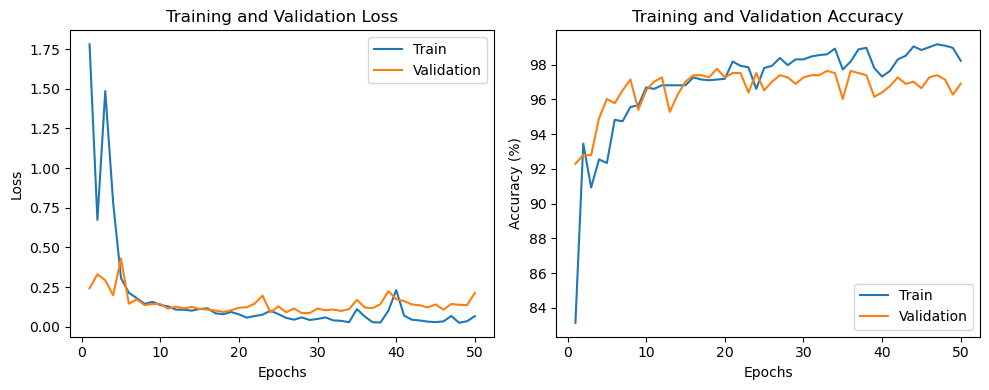

ROC-AUC Score: 0.8724


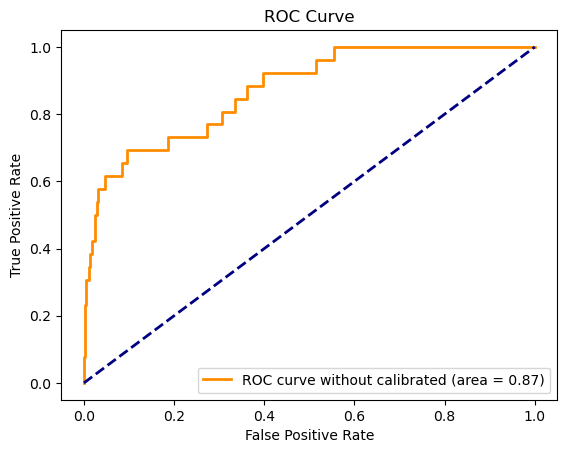

Accuracy:  0.9639751552795031
Precision:  0.9642994111243072
Recall:  0.9636970730321114
F1 Score:  0.9639250531195673
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 45, 20, 20]             225
            Conv2d-2           [-1, 45, 20, 20]             225
         MaxPool2d-3           [-1, 45, 19, 19]               0
         MaxPool2d-4           [-1, 45, 19, 19]               0
            Conv2d-5           [-1, 76, 18, 18]          13,756
            Conv2d-6           [-1, 76, 18, 18]          13,756
         MaxPool2d-7           [-1, 76, 17, 17]               0
         MaxPool2d-8           [-1, 76, 17, 17]               0
           Dropout-9           [-1, 76, 17, 17]               0
          Dropout-10           [-1, 76, 17, 17]               0
           Linear-11                  [-1, 128]       2,811,520
           Linear-12                    [-1, 2] 

In [9]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score
from torchsummary import summary


# Cargar el archivo PKL
with open('data_trains.pkl', 'rb') as f:
    data = pickle.load(f)

# Extraer las imágenes y etiquetas
sci_images = np.array(data['sci_images'])
labels = np.array(data['labels'])

# Ajustar las dimensiones de las imágenes
images = sci_images.reshape(-1, 1, 21, 21)
labels = labels.reshape(-1)

# Convertir a tensores
images = torch.tensor(images).float()
labels = torch.tensor(labels).long()

# Crear TensorDataset
dataset = TensorDataset(images, labels)

# Dividir en entrenamiento, validación y prueba
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Crear DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Definir el modelo CNN
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 45, kernel_size=2, stride=1) 
        self.conv2 = nn.Conv2d(45, 76, kernel_size=2, stride=1) 
        self.pool = nn.MaxPool2d(2,1)
        self.dropout = nn.Dropout(p=0.50)
        self.fc1 = nn.Linear(17*17*76, 38)  
        self.fc2 = nn.Linear(38, 2)  
        
        self._to_linear = None
        self.convs = nn.Sequential(
            self.conv1,
            nn.ReLU(),
            self.pool,
            self.dropout,
            self.conv2,
            nn.ReLU(),
            self.pool,
            self.dropout
        )
        self._get_conv_output((1, 21, 21))
        
        # Usar el tamaño calculado para la capa completamente conectada
        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 2)
    def _get_conv_output(self, shape):
        o = torch.zeros(1, *shape)
        o = self.convs(o)
        self._to_linear = int(o.numel())    

    def forward(self, x):
        x = self.pool(F.relu((self.conv1(x))))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 17*17*76)
        x = F.relu(self.fc1(x))               
        x = self.fc2(x)                       
        return x
        
        
    

# Inicializar el modelo, criterio y optimizador
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Función para entrenar el modelo
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        epoch_train_loss = running_train_loss / len(train_loader)
        epoch_train_accuracy = correct_train / total_train * 100
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)
        
        # Validation
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        epoch_val_loss = running_val_loss / len(val_loader)
        epoch_val_accuracy = correct_val / total_val * 100
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.2f}%, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.2f}%")
    
    return train_losses, val_losses, train_accuracies, val_accuracies

# Entrenar el modelo
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50)

# Graficar las curvas de aprendizaje
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, 51), train_losses, label='Train')
plt.plot(range(1, 51), val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 51), train_accuracies, label='Train')
plt.plot(range(1, 51), val_accuracies, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Calcular ROC-AUC
def MCDROP(model, data_loader, num_samples=100):
    model.eval()  # Poner el modelo en modo de evaluación
    dropout_preds = []
    
    for _ in range(num_samples):
        preds = []
        for inputs, _ in data_loader:
            with torch.no_grad():
                # Habilitar dropout durante la inferencia
                model.dropout.train()
                outputs = model(inputs)
                preds.append(F.softmax(outputs, dim=1).cpu().detach().numpy())
        dropout_preds.append(np.concatenate(preds))
    
    return np.array(dropout_preds)

# Obtener predicciones con incertidumbre usando Monte Carlo Dropout
dropout_predictions = MCDROP(model, test_loader, num_samples=100)

# Calcular la media y la incertidumbre
mean_predictions = np.mean(dropout_predictions, axis=0)
uncertainty = np.std(dropout_predictions, axis=0)

# Calcular ROC-AUC
y_test = []
for _, labels in test_loader:
    y_test.extend(labels.numpy())
y_test = np.array(y_test)

y_pred = np.argmax(mean_predictions, axis=1)
e_i = (y_pred != y_test).astype(int)
auc_score = roc_auc_score(e_i, 1 - np.max(mean_predictions, axis=1))
print(f'ROC-AUC Score: {auc_score:.4f}')

# Graficar la curva ROC
fpr, tpr, _ = roc_curve(e_i, 1 - np.max(mean_predictions, axis=1))
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve without calibrated (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


#calculo de metricas como acurracy, F1, Recall y precision
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy().flatten())

print("Accuracy: ", accuracy_score(all_labels, all_preds))
print("Precision: ", precision_score(all_labels, all_preds, average='macro'))
print("Recall: ", recall_score(all_labels, all_preds, average='macro'))
print("F1 Score: ", f1_score(all_labels, all_preds, average='macro'))
summary(model, input_size=(1, 21, 21)) 

Validation ROC-AUC Score: 0.9865


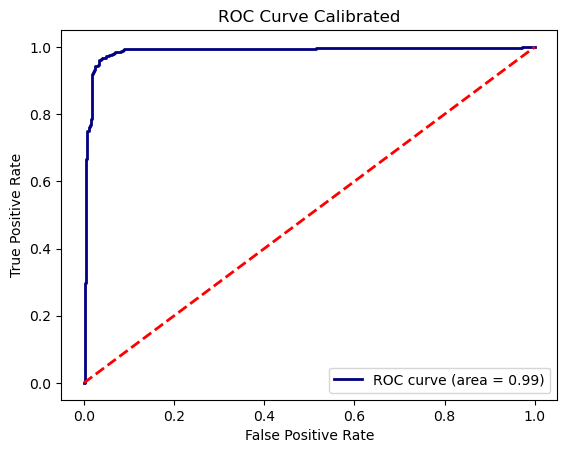

Accuracy:  0.968944099378882
Precision:  0.9694342331637642
Recall:  0.9685990338164252
F1 Score:  0.9688949476121367
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 45, 20, 20]             225
            Conv2d-2           [-1, 45, 20, 20]             225
         MaxPool2d-3           [-1, 45, 19, 19]               0
         MaxPool2d-4           [-1, 45, 19, 19]               0
            Conv2d-5           [-1, 76, 18, 18]          13,756
            Conv2d-6           [-1, 76, 18, 18]          13,756
         MaxPool2d-7           [-1, 76, 17, 17]               0
         MaxPool2d-8           [-1, 76, 17, 17]               0
           Dropout-9           [-1, 76, 17, 17]               0
          Dropout-10           [-1, 76, 17, 17]               0
           Linear-11                  [-1, 128]       2,811,520
           Linear-12                    [-1, 2]  

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Extraer características del modelo de PyTorch
def extract_features(model, loader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, lbls in loader:
            output = model.convs(inputs)
            output = output.view(output.size(0), -1)
            features.append(output)
            labels.append(lbls)
    return torch.cat(features), torch.cat(labels)

train_features, train_labels = extract_features(model, train_loader)
val_features, val_labels = extract_features(model, val_loader)

train_features = train_features.numpy()
train_labels = train_labels.numpy()
val_features = val_features.numpy()
val_labels = val_labels.numpy()

# Entrenar el clasificador base y calibrar
base_clf = LogisticRegression(max_iter=2000)
base_clf.fit(train_features, train_labels)

calibrated_clf = CalibratedClassifierCV(estimator=base_clf, method='sigmoid', cv='prefit')
calibrated_clf.fit(train_features, train_labels)

# Obtener probabilidades en el conjunto de validación
val_probs = calibrated_clf.predict_proba(val_features)[:, 1]

# Calcular ROC-AUC
val_auc = roc_auc_score(val_labels, val_probs)
print(f'Validation ROC-AUC Score: {val_auc:.4f}')

# Graficar la curva ROC
fpr, tpr, _ = roc_curve(val_labels, val_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='navy', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Calibrated')
plt.legend(loc='lower right')
plt.show()

#calculo de metricas como acurracy, F1, Recall y precision
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy().flatten())

print("Accuracy: ", accuracy_score(all_labels, all_preds))
print("Precision: ", precision_score(all_labels, all_preds, average='macro'))
print("Recall: ", recall_score(all_labels, all_preds, average='macro'))
print("F1 Score: ", f1_score(all_labels, all_preds, average='macro'))
summary(model, input_size=(1, 21, 21)) 

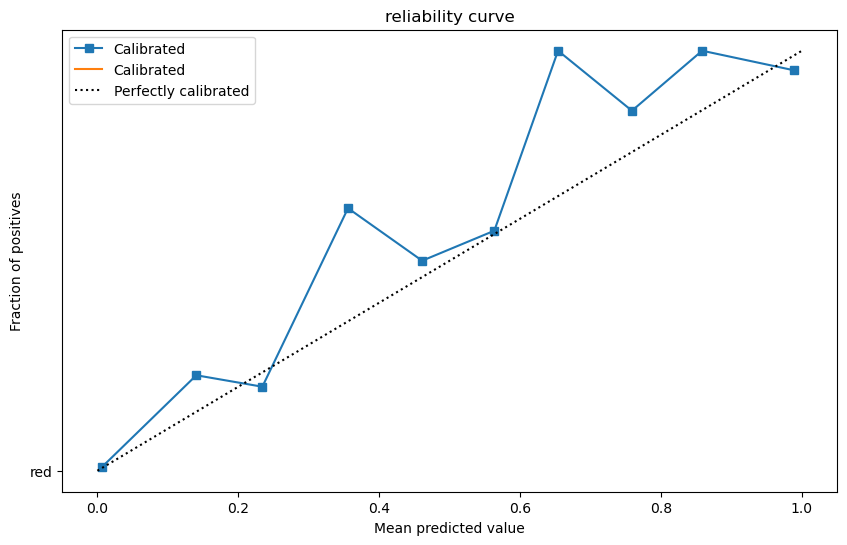

Brier Score: 0.0411


In [23]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, brier_score_loss
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

test_features, test_labels = extract_features(model, test_loader)
test_features = test_features.numpy()
test_labels = test_labels.numpy()

# Calibrar usando Isotonic Regression
calibrated_clf = CalibratedClassifierCV(estimator=base_clf, method='sigmoid', cv='prefit')
calibrated_clf.fit(train_features, train_labels)

# Obtener probabilidades en el conjunto de prueba
test_probs = calibrated_clf.predict_proba(test_features)[:, 1]

# Calcular las curvas de calibración
fraction_of_positives, mean_predicted_value = calibration_curve(test_labels, test_probs, n_bins=10)

# Graficar la curva de calibración
plt.figure(figsize=(10, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", "red", label='Calibrated')
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.title('reliability curve')
plt.legend()
plt.show()

# Calcular la puntuación de Brier
brier_score = brier_score_loss(test_labels, test_probs)
print(f'Brier Score: {brier_score:.4f}')

In [16]:
import pickle

# Extraer datos de entrenamiento
train_images = []
train_labels = []
for img, label in train_dataset:
    train_images.append(img.numpy())
    train_labels.append(label.numpy())

train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Extraer datos de validación
val_images = []
val_labels = []
for img, label in val_dataset:
    val_images.append(img.numpy())
    val_labels.append(label.numpy())

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Extraer datos de prueba
test_images = []
test_labels = []
for img, label in test_dataset:
    test_images.append(img.numpy())
    test_labels.append(label.numpy())

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Guardar los conjuntos de datos en archivos PKL
with open('train_data.pkl', 'wb') as f:
    pickle.dump({'images': train_images, 'labels': train_labels}, f)

with open('val_data.pkl', 'wb') as f:
    pickle.dump({'images': val_images, 'labels': val_labels}, f)

with open('test_data.pkl', 'wb') as f:
    pickle.dump({'images': test_images, 'labels': test_labels}, f)

print("Datos de entrenamiento, validación y prueba guardados en archivos PKL.")


Datos de entrenamiento, validación y prueba guardados en archivos PKL.
